# Intelligent Credit Risk Scoring System 🏦
### Milestone 1: Comprehensive Machine Learning Workflow

This notebook covers an end-to-end Machine Learning pipeline for predicting credit risk, including advanced Exploratory Data Analysis (EDA), Data Preprocessing, Model Training, Evaluation, and Model Explainability. 


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

import warnings
warnings.filterwarnings('ignore')
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')
sns.set_palette("muted")


## STEP 1: Advanced Exploratory Data Analysis (EDA)
In this section, we load the dataset and deeply analyze its distributions, correlations, and relationships to the target variable (`dlq_2yrs`).


In [17]:
# Load the dataset
df = pd.read_csv('../data/Credit Risk Benchmark Dataset.csv')

print("Dataset Shape:", df.shape)
display(df.head())


Dataset Shape: (16714, 11)


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs
0,0.006999,38.0,0.0,0.302150,5440.0,4.0,0.0,1.0,0.0,3.0,0
1,0.704592,63.0,0.0,0.471441,8000.0,9.0,0.0,1.0,0.0,0.0,0
2,0.063113,57.0,0.0,0.068586,5000.0,17.0,0.0,0.0,0.0,0.0,0
3,0.368397,68.0,0.0,0.296273,6250.0,16.0,0.0,2.0,0.0,0.0,0
4,1.000000,34.0,1.0,0.000000,3500.0,0.0,0.0,0.0,0.0,1.0,0


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rev_util     16714 non-null  float64
 1   age          16714 non-null  float64
 2   late_30_59   16714 non-null  float64
 3   debt_ratio   16714 non-null  float64
 4   monthly_inc  16714 non-null  float64
 5   open_credit  16714 non-null  float64
 6   late_90      16714 non-null  float64
 7   real_estate  16714 non-null  float64
 8   late_60_89   16714 non-null  float64
 9   dependents   16714 non-null  float64
 10  dlq_2yrs     16714 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB

Missing Values:
rev_util       0
age            0
late_30_59     0
debt_ratio     0
monthly_inc    0
open_credit    0
late_90        0
real_estate    0
late_60_89     0
dependents     0
dlq_2yrs       0
dtype: int64


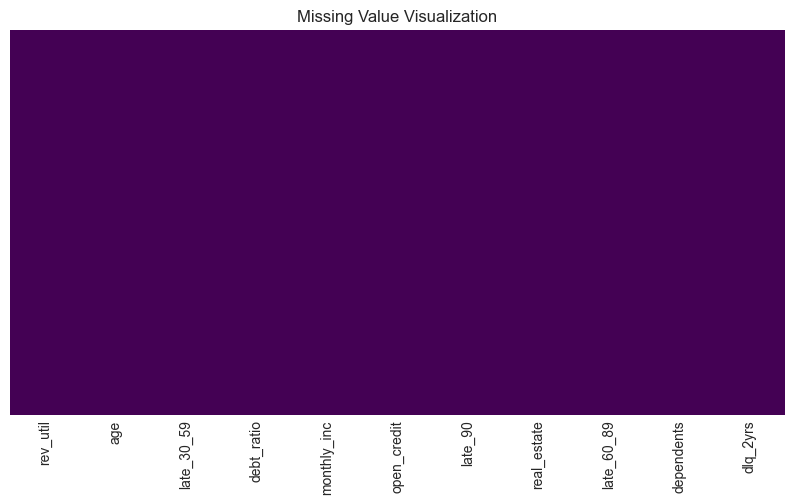

In [4]:
# 1. Dataset Overview & Missing Values
print("Data Information:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Value Visualization')
plt.show()


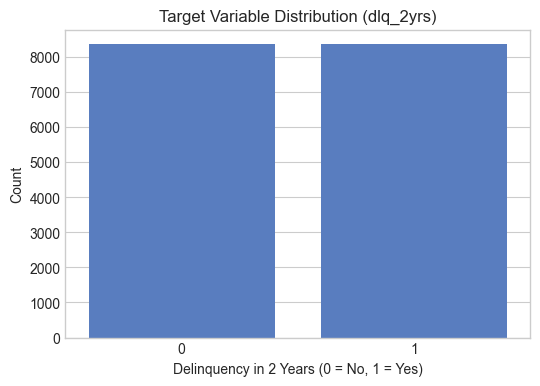

Class Imbalance: 50.00% of applicants are defaults (1).


In [18]:
# 2. Target Variable Distribution & Class Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='dlq_2yrs', data=df)
plt.title('Target Variable Distribution (dlq_2yrs)')
plt.xlabel('Delinquency in 2 Years (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Calculate Imbalance percentage
default_pct = (df['dlq_2yrs'].sum() / len(df)) * 100
print(f"Class Imbalance: {default_pct:.2f}% of applicants are defaults (1).")


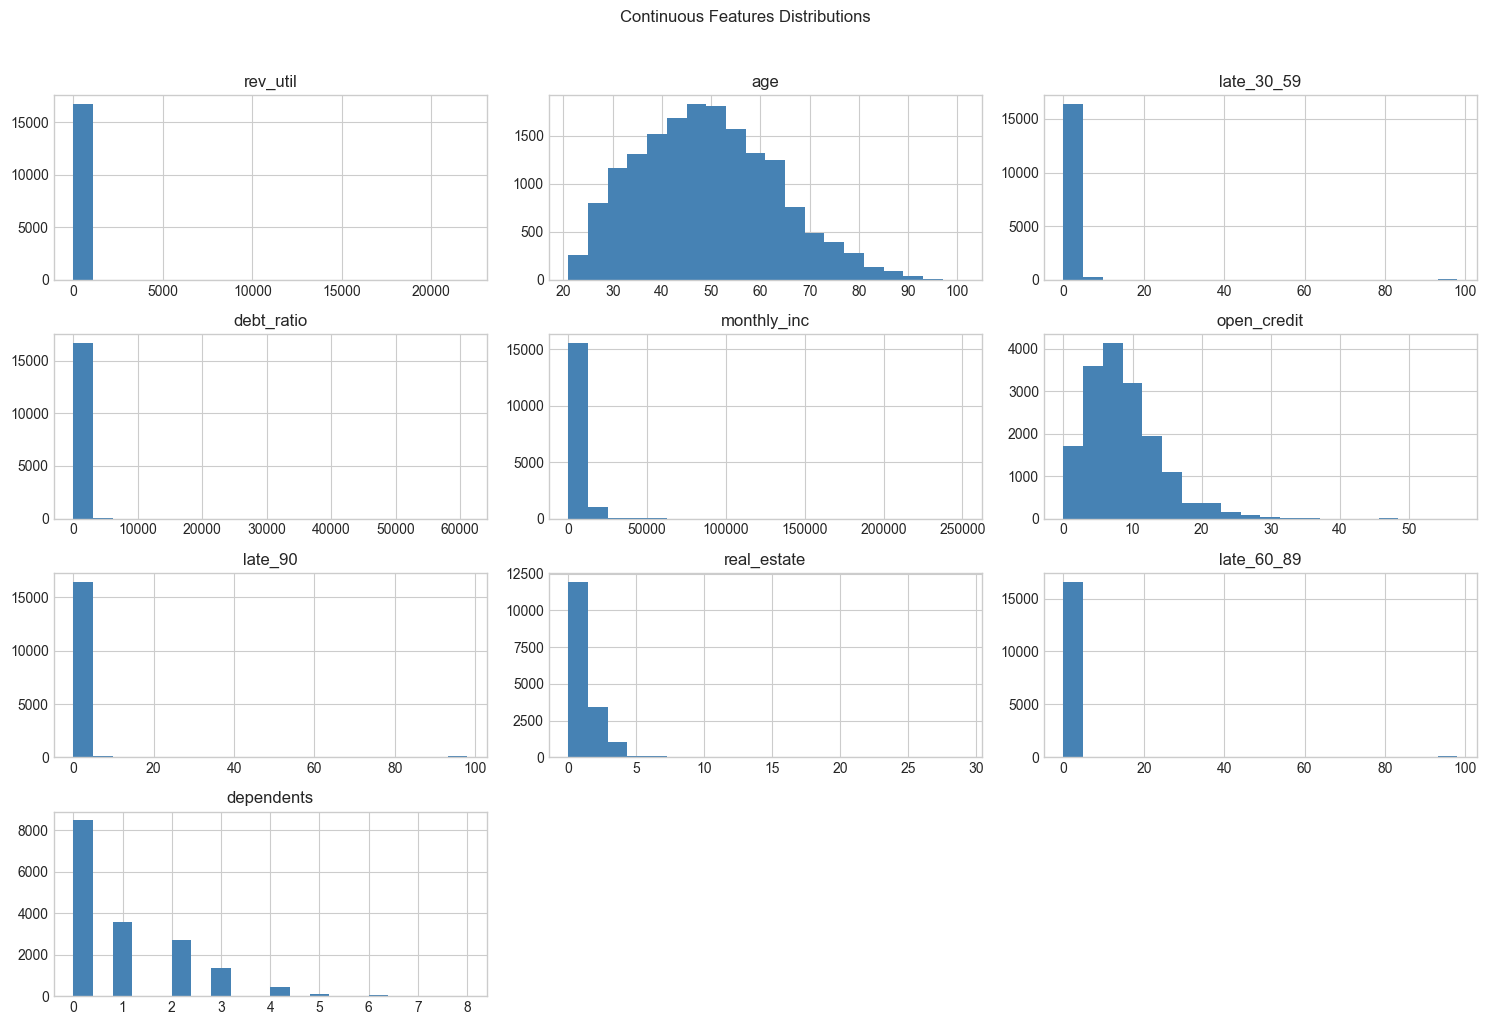

In [19]:
# 3. Feature Distribution Histograms
df.drop('dlq_2yrs', axis=1).hist(bins=20, figsize=(15, 10), color='steelblue')
plt.suptitle('Continuous Features Distributions', y=1.02)
plt.tight_layout()
plt.show()


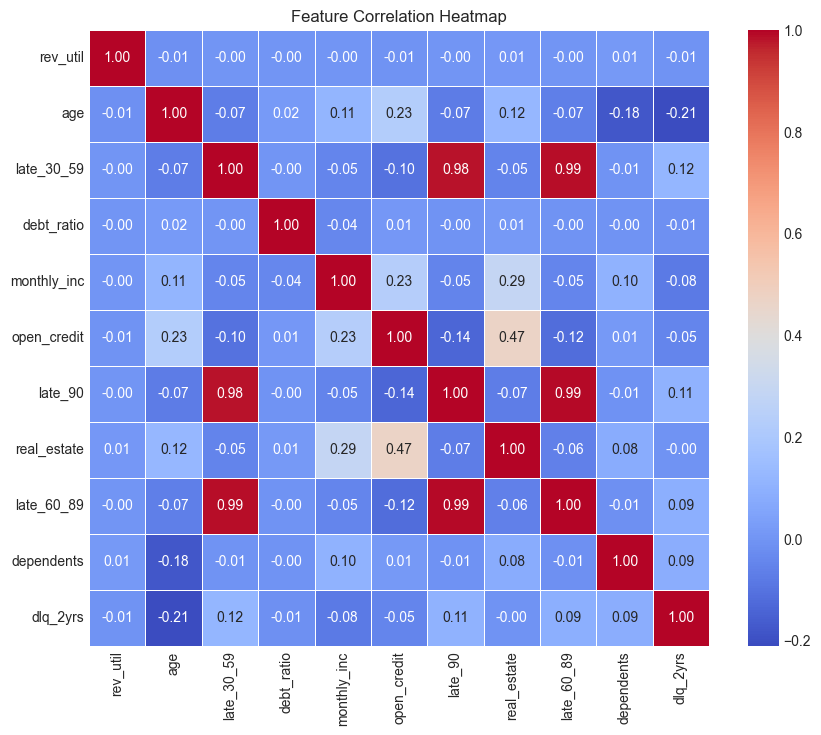

In [20]:
# 4. Correlation Heatmap
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


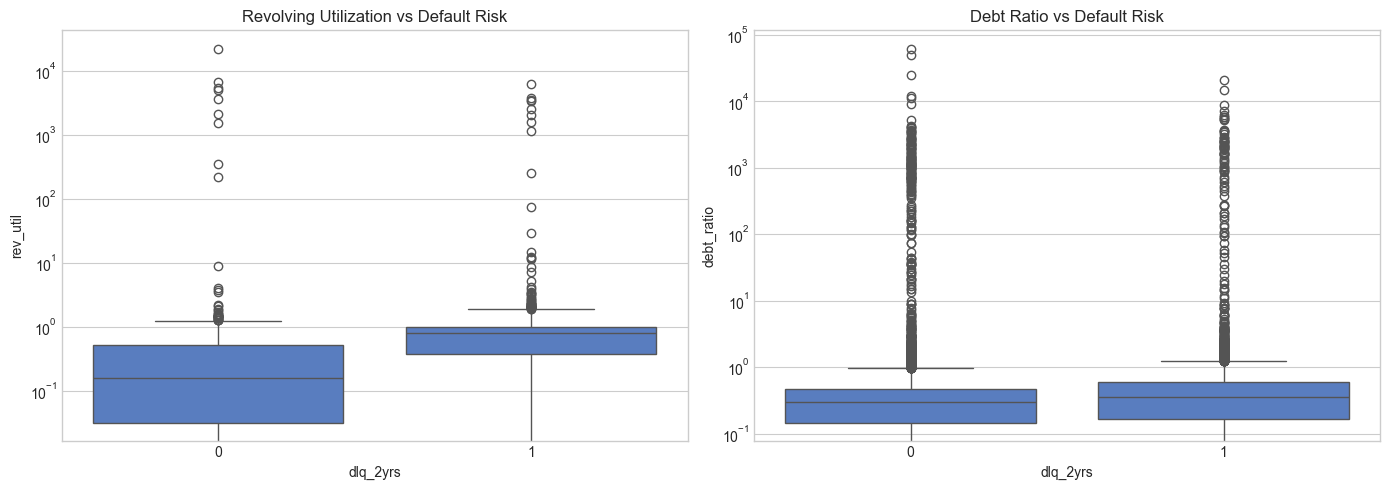

In [21]:
# 5. Boxplots: Important Features vs Target
# Visualizing Revolving Utilization and Debt Ratio against Target
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Use log scale for rev_util to handle extreme outliers for visualization
sns.boxplot(x='dlq_2yrs', y='rev_util', data=df, ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('Revolving Utilization vs Default Risk')

sns.boxplot(x='dlq_2yrs', y='debt_ratio', data=df, ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title('Debt Ratio vs Default Risk')

plt.tight_layout()
plt.show()


## STEP 2: Data Preprocessing
We handle missing values using median imputation (robust to outliers), encode any categorical data if present, and stratify-split the data to preserve the default ratio.


In [22]:
# Handling Missing Values (Median Imputation)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# One-hot encoding for categorical text columns (if any)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate Features (X) and Target (y)
TARGET_COL = 'dlq_2yrs'
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Train-Test Split with Stratification
# Stratify ensures both train and test sets have the same proportion of default (Class 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")


Training features shape: (13371, 10)
Testing features shape: (3343, 10)


## STEP 3: Train Multiple ML Models
We train a linear model (Logistic Regression) alongside tree-based approaches (Decision Tree and Random Forest) to compare learning behaviors.


In [23]:
# Initialize Models
# We use class_weight='balanced' to handle the default class imbalance
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

# Dictionary to hold trained models
trained_models = {}

print("Training Models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name} trained.")


Training Models...
Logistic Regression trained.
Decision Tree trained.
Random Forest trained.
